In [129]:
# VARIABLES
CLICK_PROB = .2
CLICK_NSR = .5

CLOCK_TICK_PROB = .1
CLOCK_TICK_NSR = .6

COUGHING_PROB = .1
COUGHING_NSR = .2

KEYBOARD_PROB = .4
KEYBOARD_NSR = 1.

WIND_PROB = .2
WIND_NSR = .4

WHITE_NOISE_PROB = .1

NO_NOISE_PROB = .05

REVERB_PROB = .05

NOISE_LEVEL = .4

In [1]:
!pip install torchaudio==0.7.0

     |████████████████████████████████| 7.6MB 13.4MB/s 


In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchvision
import numpy as np
from torchsummary import torchsummary
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import os
from glob import glob

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Get Librispeech dataset, and some noise 

In [4]:
# train_dataset = ta.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
train_dataset = ta.datasets.LIBRISPEECH("./", url="dev-clean", download=True)

In [30]:
!curl -L -o noises.zip https://github.com/indrasweb/chvoice/raw/main/noises.zip
!unzip -q noises.zip
!rm -rf noises/.DS_Store

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133  100   133    0     0   1220      0 --:--:-- --:--:-- --:--:--  1220
100 15.7M  100 15.7M    0     0  46.1M      0 --:--:-- --:--:-- --:--:-- 46.1M
replace noises/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Signal Processing Utils

In [7]:
class DSP:

    def __init__(self, n_fft=254, hop_len=None):
        """ signal processing utils using torchaudio
        """
        self.n_fft = n_fft
        self.hop_len = n_fft//2 if hop_len is None else hop_len
        self.stft = ta.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=self.hop_len,
            win_length=n_fft,
            power=None
        )
        self.amplitude_to_db = ta.transforms.AmplitudeToDB()
        self.db_to_amplitude = lambda x: T.pow(T.pow(10.0, 0.1 * x), 1.)

    def sig_to_db_phase(self, sig):
        """ get dB and phase spectrograms of signal
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
        """
        # represent input signal in time-frequency domain
        stft = self.stft(sig)
        # magnitude = amount of power/volume for each phase = frequency
        mag, phase = ta.functional.magphase(stft)
        # put magnitudes on log scale
        db = self.amplitude_to_db(mag)

        return db, phase

    def db_phase_to_sig(self, db, phase):
        """ get wav signal from db and phase spectrograms.
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
                    ... do stuff to db ...
                >>> recovered_sig = chvoice.spec_to_sig(db, phase)
        """
        # go from log scale back to linear
        mag = self.db_to_amplitude(db)
        # recover full fourier transform of signal
        real = mag * T.cos(phase)
        imaginary = mag * T.sin(phase)
        complex = T.stack((real, imaginary), dim=-1)
        # inverse fourier transform to get signal
        sig = complex.istft(
            n_fft=self.n_fft,
            hop_length=self.hop_len
        )

        return sig

## Pre-processing and augmentation

In [96]:
class ReverbEcho:
    """
    CREDIT :: https://github.com/facebookresearch/denoiser/blob/e27bf5cdcda6e6ffc3a332763411d864210f94c8/denoiser/augment.py

    Hacky Reverb but runs on GPU without slowing down training.
    This reverb adds a succession of attenuated echos of the input
    signal to itself. Intuitively, the delay of the first echo will happen
    after roughly 2x the radius of the room and is controlled by `first_delay`.
    Then RevEcho keeps adding echos with the same delay and further attenuation
    until the amplitude ratio between the last and first echo is 1e-3.
    The attenuation factor and the number of echos to adds is controlled
    by RT60 (measured in seconds). RT60 is the average time to get to -60dB
    (remember volume is measured over the squared amplitude so this matches
    the 1e-3 ratio).
    At each call to RevEcho, `first_delay`, `initial` and `RT60` are
    sampled from their range. Then, to prevent this reverb from being too regular,
    the delay time is resampled uniformly within `first_delay +- 10%`,
    as controlled by the `jitter` parameter. Finally, for a denser reverb,
    multiple trains of echos are added with different jitter noises.
    Args:
        - initial: amplitude of the first echo as a fraction
            of the input signal. For each sample, actually sampled from
            `[0, initial]`. Larger values means louder reverb. Physically,
            this would depend on the absorption of the room walls.
        - rt60: range of values to sample the RT60 in seconds, i.e.
            after RT60 seconds, the echo amplitude is 1e-3 of the first echo.
            The default values follow the recommendations of
            https://arxiv.org/ftp/arxiv/papers/2001/2001.08662.pdf, Section 2.4.
            Physically this would also be related to the absorption of the
            room walls and there is likely a relation between `RT60` and
            `initial`, which we ignore here.
        - first_delay: range of values to sample the first echo delay in seconds.
            The default values are equivalent to sampling a room of 3 to 10 meters.
        - repeat: how many train of echos with differents jitters to add.
            Higher values means a denser reverb.
        - jitter: jitter used to make each repetition of the reverb echo train
            slightly different. For instance a jitter of 0.1 means
            the delay between two echos will be in the range `first_delay +- 10%`,
            with the jittering noise being resampled after each single echo.
        - keep_clean: fraction of the reverb of the clean speech to add back
            to the ground truT. 0 = dereverberation, 1 = no dereverberation.
        - sample_rate: sample rate of the input signals.
    """

    def __init__(self, initial=0.2, rt60=(0.1, 1.0), first_delay=(0.01, 0.03),
                 repeat=31, jitter=0.1, keep_clean=0.1, sample_rate=16000):
        super().__init__()
        self.initial = initial
        self.rt60 = rt60
        self.first_delay = first_delay
        self.repeat = repeat
        self.jitter = jitter
        self.keep_clean = keep_clean
        self.sample_rate = sample_rate

    def reverb(self, sig):
        """
        Return the reverb for a single sig.
        """

        initial = random.random() * self.initial
        first_delay = random.uniform(*self.first_delay)
        rt60 = random.uniform(*self.rt60)

        length = sig.shape[-1]
        reverb = T.zeros_like(sig)
        
        for _ in range(self.repeat):
            frac = 1  # what fraction of the first echo amplitude is still here
            echo = initial * sig
            while frac > 1e-3:
                # First jitter noise for the delay
                jitter = 1 + self.jitter * random.uniform(-1, 1)
                delay = min(
                    1 + int(jitter * first_delay * self.sample_rate),
                    length)
                # Delay the echo in time by padding with zero on the left
                echo = F.pad(echo[:, :, :-delay], (delay, 0))
                reverb += echo

                # Second jitter noise for the attenuation
                jitter = 1 + self.jitter * random.uniform(-1, 1)
                # we want, with `d` the attenuation, d**(rt60 / first_ms) = 1e-3
                # i.e. log10(d) = -3 * first_ms / rt60, so that
                attenuation = 10**(-3 * jitter * first_delay / rt60)
                echo *= attenuation
                frac *= attenuation

        return reverb

In [130]:
class Noiser:

    def __init__(self, noise_dir, noise_lvl=0.4, probs=[], nsr_scalar=[]):
        """ add noise to signal, where noise is randomly 
            selected wav from noise_dir.
            noise_lvl = ratio of noise to signal (additive)
        """
        rs = ta.transforms.Resample()
        self.nsr = noise_lvl
        self.noises = []
        self.probs = []
        self.nsr_scalar = []
        self.reverber = ReverbEcho()
        noise_dirs = os.listdir(noise_dir)
        noise_dirs.sort()
        for index, directory in enumerate(noise_dirs):
          directory = "./noises/" + str(directory)
          print(directory)
          print(probs[index])
          fns = os.listdir(directory)
          for fn in fns:
            noise = ta.load(os.path.join(directory, fn))
            rs = ta.transforms.Resample(noise[1], 16000)(noise[0])
            self.noises.append(rs.squeeze(0))
            self.probs.append(probs[index])
            self.nsr_scalar.append(nsr_scalar[index])
        
    def add_noise(self, sig):
        """ sig is expected to be one-dimensional (N,)
            snr = maximum signal to noise ratio 
        """
        # stochastic amount of noise
        noise_lvl = np.random.random() * self.nsr

        # 10% of the time just add white noise
        r = np.random.random()
        if r > (1-WHITE_NOISE_PROB):
            white_noise = T.normal(
                mean=0., 
                std=0.025, size=sig.shape
            )
            return sig + white_noise*self.nsr

        elif r > (1- WHITE_NOISE_PROB - NO_NOISE_PROB):
          return sig

        elif r > (1 - WHITE_NOISE_PROB - NO_NOISE_PROB - REVERB_PROB):
          sig_reverb = self.reverber.reverb(sig.unsqueeze(0).unsqueeze(0))
          sig_reverb = sig_reverb.squeeze(0).squeeze(0)
          return sig_reverb

        # otherwise add a noise from the archive
        j = random.randint(1, 3)
        for i in range(0, j):
          noise_index = random.choices(range(len(self.noises)), weights=self.probs)[0]
          noise = self.noises[noise_index]
          nsr = self.nsr * self.nsr_scalar[noise_index] *  (1/j) * (.5 + (T.rand(size=(1,))[0] / 2))
          if len(noise) < len(sig):
              n_repeats = int(np.ceil(len(sig) / len(noise)))
              noise = T.repeat_interleave(noise, n_repeats)

          sig = sig + noise[:len(sig)]*nsr

        return sig

In [9]:
denormalize = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=0., std=1/18),
    torchvision.transforms.Normalize(mean=32., std=1.)
])

normalize = torchvision.transforms.Normalize(mean=-32., std=18)

def preprocess(X, dsp, noiser):
    clean = []
    noisy = []
    wavs = [d[0] for d in X]

    for wav in wavs:

        db, phase = dsp.sig_to_db_phase(wav)
        if db.size(2) < 128:
            continue

        # make clean chunks of audio
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        clean.append(chunks)

        # make corresponding noisy chunks of audio
        aug_wav = noiser.add_noise(wav.squeeze(0))
        db, phase = dsp.sig_to_db_phase(aug_wav.unsqueeze(0))
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        noisy.append(chunks)

    clean = T.vstack(clean).unsqueeze(1)
    noisy = T.vstack(noisy).unsqueeze(1)
    
    return clean, noisy

## Model Definition (UNet)

In [11]:
### CREDIT : https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = T.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Train

In [131]:
dsp = DSP(254)
probs = [CLICK_PROB, CLOCK_TICK_PROB, COUGHING_PROB, KEYBOARD_PROB, WIND_PROB]
nsr_scalars = [CLICK_NSR, CLOCK_TICK_NSR, COUGHING_NSR, KEYBOARD_NSR, WIND_NSR]
noiser = Noiser("./noises/", noise_lvl=NOISE_LEVEL, probs=probs, nsr_scalar=nsr_scalars)

train_loader = T.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

model = UNet(1, 1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()

./noises/click-mono
0.2
./noises/clock-tick-mono
0.1
./noises/coughing-mono
0.1
./noises/keyboard-mono
0.4
./noises/wind-mono
0.2


In [ ]:
for epoch in range(1, 11):
    print(f'----- EPOCH {epoch} -----')
    for i, (clean, noisy) in enumerate(train_loader):
        clean = clean[:40,:,:,:].to(DEVICE)
        noisy = noisy[:40,:,:,:].to(DEVICE)
        optim.zero_grad()
        pred = model(noisy)
        loss = crit(pred, clean)
        loss.backward()
        optim.step()
        print(i, loss.item())

----- EPOCH 1 -----
0 0.5749878883361816
1 0.4696008861064911
2 0.348304808139801
3 0.19971202313899994
4 0.2680077850818634
5 0.4275439381599426
6 0.21812279522418976
7 0.1450863927602768
8 0.15048108994960785
9 0.16666361689567566
10 0.15927231311798096
11 0.13871191442012787
12 0.19304589927196503
13 0.09571107476949692
14 0.11561568826436996
15 0.08528027683496475
16 0.14270931482315063
17 0.08404075354337692
18 0.08064096421003342
19 0.1364779770374298
20 0.1107763797044754
21 0.09252841770648956
22 0.06328979134559631
23 0.09107840061187744
24 0.1279935985803604
25 0.07434338331222534
26 0.05096698924899101
27 0.10024397820234299
28 0.11653698980808258
29 0.09767293184995651
30 0.3860187530517578
31 0.11090337485074997
32 0.08066896349191666
33 0.1024172306060791
34 0.060497500002384186
35 0.08645587414503098
36 0.12166409939527512
37 0.08283897489309311
38 0.12552177906036377
39 0.09588818997144699
40 0.5036905407905579
41 0.10773017257452011
42 0.1321333944797516
43 0.404222339

KeyboardInterrupt: ignored

# Evaluate

In [ ]:
def evaluate(wav, in_sig, model, plot_spectrograms=True):
    
    db, phase = dsp.sig_to_db_phase(wav)
    db_no_noise, phase_no_noise = dsp.sig_to_db_phase(in_sig)

    if plot_spectrograms:
        print('dB spectrogram in noisy')
        plt.imshow(db[0])
        plt.show()

        print('dB spectogram in without noise')
        plt.imshow(db_no_noise[0])
        plt.show()

    assert db.size(2) >= 128, 'wav too small'

    chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
    #chunks = chunks.unsqueeze(1).to(DEVICE)
    chunks = normalize(chunks).unsqueeze(1).to(DEVICE)
                 
    with T.no_grad():
        proc = denormalize(model(chunks))
    
    db_out = T.cat([c for c in proc.squeeze(1)], dim=1).cpu()
    
    if plot_spectrograms:
        print('db spectrogram out')
        plt.imshow(db_out.numpy())
        plt.show()
    
    phase_clipped = phase[0,:,:db_out.size(1)]
    sig = dsp.db_phase_to_sig(db_out, phase_clipped)

    # Why is the output longer haha
    diff = db_out.numpy() - db[0].numpy()[:, :db_out.numpy().shape[1]]
    if plot_spectrograms:
        print('DIFF')
        plt.imshow(diff)
        plt.show()

    print("Av diff value")
    print(np.sqrt(np.mean(diff*diff)))
    
    return sig

Load a sample, and add noise to it

In [126]:
in_sig = train_dataset[87][0]
Audio(in_sig, rate=16000)

In [134]:
wobbly = noiser.add_noise(in_sig.squeeze(0)).unsqueeze(0)
Audio(wobbly, rate=16000)

In [113]:
reverber = ReverbEcho()
print(in_sig.shape)
print(in_sig.unsqueeze(0).shape)
sig_reverb = reverber.reverb(in_sig.unsqueeze(0))
sig_reverb = sig_reverb.squeeze(0)
Audio(sig_reverb, rate=16000)

torch.Size([1, 78720])
torch.Size([1, 1, 78720])


dB spectrogram in


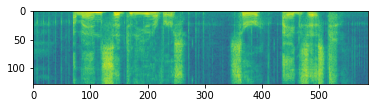

db spectrogram out


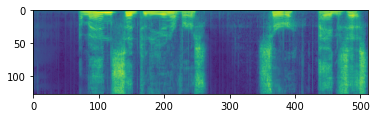

In [ ]:
model = model.eval()
out_sig = evaluate(wobbly, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)